In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.append("../")

from C4_theo_asymptotique__trapz import C4_court, C4_long
from DoubleRigidWallOverdampedBrownExp_Cython import RigidWallOverdampedLangevin3D
from Physic_function_problem import *
import cythonised_simu_part

from scipy.integrate import quad
from scipy.io import loadmat
from scipy.optimize import curve_fit
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from numpy import trapz
import matplotlib.gridspec as gridspec
from matplotlib.collections import LineCollection
from mpltools import annotation
from scipy.optimize import curve_fit

import csv


def cm2inch(value):
    return value / 2.54

from tqdm import tqdm


from matplotlib import rc
import seaborn as sns
custom_params = {
    "xtick.direction": "in",
    "ytick.direction": "in",
    "lines.markeredgecolor": "k",
    "lines.markeredgewidth": 0.3,
    "figure.dpi": 200,
    "text.usetex": True,
    "font.family": "serif",
    "font.size":8,
    'axes.titlesize':10,
    'axes.labelsize':10,
}
# sns.set_context("notebook", rc={"lines.linewidth": 3})


sns.set_theme(context = "paper", style="ticks", rc=custom_params)

In [35]:
# Param fixé comme expériences
a = 1.519e-6 #1.12e-6/2
H = 4e-6
lD = 88.0e-9 #Répultion mur
kBT=1.38e-23*300
lB = 526e-9 #gravité
B = 5.0
eta=0.001

zz = np.linspace(-H+H*1e-3, H-H*1e-3, 1000)

dt = 1e-2
Nt = 10000000
Nt_sub = 1
tt = np.linspace(dt, dt*Nt, Nt)

In [3]:
mean_Dx = np.trapz(P_eq(zz, B, lD, lB, H)/np.trapz(P_eq(zz, B, lD, lB, H), zz)*D_para(zz, a, eta, H), zz)
mean_Dz = np.trapz(P_eq(zz, B, lD, lB, H)/np.trapz(P_eq(zz, B, lD, lB, H), zz)*D_perp(zz, a, eta, H), zz)

In [4]:
import glob

# results$[Nj, dt, dX]$

data_calcul_pdf/ = datas petit gap sans Mersenne Twister (moyenné sur 2000 simus)

data_calcul_pdf_4um/ = data petit gap (4 micron) AVEC Mersenne Twister (déjà moyénné sur 50 000 simus)

In [5]:
bins = 100

files = glob.glob("data_calcul_pdf_4um/*")

results = np.zeros([(len(files)), (len(np.load(files[0]))), bins])
for n, file in enumerate(files):
    result = np.load(file)
    
    for m, line in  enumerate(result):
        results[n, m, :] = list(line)
        

# $\Delta X$

In [6]:
dt_C4 = [*np.arange(1, 10), *np.arange(10, 100, 10), *np.arange(100, 1000, 100), *np.arange(1000, 10000, 1000), 10000]
Sigma = 7
D_0 = 4e-21 / (6*np.pi*0.001*a)
dt_s_C4 = np.array(dt_C4) * dt

limits = np.sqrt(2*D_0*dt_s_C4) * Sigma

dX_hist = []
for n in range(len(dt_C4)):
    limit = limits[n]
    _, X = np.histogram([], bins = bins, range = [-limit, + limit]) 
    dX_hist.append((X[1:]+X[:-1])/2)
    
dX_hist = np.array(dX_hist)

# Calcul du $C_4$

In [7]:
C_4 = np.zeros(len(dt_s_C4))

for n in range(len(dt_s_C4)):
    dX = dX_hist[n,:]
    data = results[:,n, :]
    PDF = np.mean(data, axis=0)
    PDF = PDF / np.trapz(PDF, dX)
    X4 = np.trapz(dX**4 * PDF, dX)
    X2 = np.trapz(dX**2 * PDF, dX)
    C_4[n] = X4 - 3*X2**2

In [19]:
Kurtosis = np.zeros(len(dt_s_C4))

for n in range(len(dt_s_C4)):
    dX = dX_hist[n,:]
    data = results[:,n, :]
    PDF = np.mean(data, axis=0)
    PDF = PDF / np.trapz(PDF, dX)
    X4 = np.trapz(dX**4 * PDF, dX)
    X2 = np.trapz(dX**2 * PDF, dX)
    Kurtosis[n] = X4/X2**2 - 3

In [8]:
dtCOURT = np.linspace(1e-2, 1e2, 1000)
dtLONG = np.linspace(1e0, 3e2, 1000)
A4_theo_x = C4_court(D=D_para, Peq=P_eq, kBT=kBT, B=B, lD=lD, lB=lB, H=H, a=a, eta=eta, dx=1e-10)

In [9]:
D4_long_theo, C4_long_theo = C4_long(V=V, Dpara=D_para, Dperp=D_perp, Peq=P_eq, kBT=kBT, B=B, lD=lD, lB=lB, H=H, a=a, eta=eta, dx=1e-7)

D4_long_theo, C4_long_theo

(2.3372837889703517e-26, 2.6543806021548225e-38)

# PDF$(\Delta X)$

In [11]:
Ntau1 = 1
dx_1 = dX_hist[Ntau1,:]
data_1 = results[:,Ntau1, :]
Mean1 = np.mean(data_1, axis=0)
Z1 = np.trapz(Mean1, dx_1)

Ntau2 = 10
dx_2 = dX_hist[Ntau2,:]
data_2 = results[:,Ntau2, :]
Mean2 = np.mean(data_2, axis=0)
Z2 = np.trapz(Mean2, dx_2)

Ntau3 = 36
dx_3 = dX_hist[Ntau3,:]
data_3 = results[:,Ntau3, :]
Mean3 = np.mean(data_3, axis=0)
Z3 = np.trapz(Mean3, dx_3)

In [12]:
mean_Dx = np.trapz(P_eq(zz, B, lD, lB, H)/np.trapz(P_eq(zz, B, lD, lB, H), zz)*D_para(zz, a, eta, H), zz)
mean_Dz = np.trapz(P_eq(zz, B, lD, lB, H)/np.trapz(P_eq(zz, B, lD, lB, H), zz)*D_perp(zz, a, eta, H), zz)

dxCOURT = np.linspace(-0.5, 0.5, 1000)
dxMID =  np.linspace(-1.5, 1.5, 1000)
dxLONG =  np.linspace(-30, 30, 1000)

In [13]:
gauss1 = gauss(x=dxCOURT*1e-6, mu=0, std=np.sqrt(2*mean_Dx*dt_s_C4[Ntau1]))
gauss2 = gauss(x=dxMID*1e-6, mu=0, std=np.sqrt(2*mean_Dx*dt_s_C4[Ntau2]))
gauss3 = gauss(x=dxLONG*1e-6, mu=0, std=np.sqrt(2*mean_Dx*dt_s_C4[Ntau3]))

# PFD$x$ theorie au temps court

In [139]:
z0 = np.linspace(-H, H, 1000)
dxx = np.linspace(-0.5e-6, 0.5e-6, 1000)
tau1 = dt_s_C4[Ntau1]

PDF_theo_court = np.zeros(len(dxx))
Peq = P_eq(z0, B, lD, lB, H)


ff = np.zeros([len(dxx), len(z0)])

# Matrice de la quantité à moyenner sur les Peq : f(dx, z)
for n, x in enumerate(dxx):
    for m, z in enumerate(z0):
        ff[n,m] = 1/(np.sqrt(4 * np.pi * dt * D_para(z, a, eta, H))) * np.exp(-(x**2)/(4 * dt * D_para(z, a, eta, H)))


In [140]:
# calcul de la PDF_dx theorique au temps court
for x in range(len(dxx)):
    PDF_theo_court[x] = np.trapz( ff[x, :]* Peq , z0)

(0.0001, 248850895.1320463)

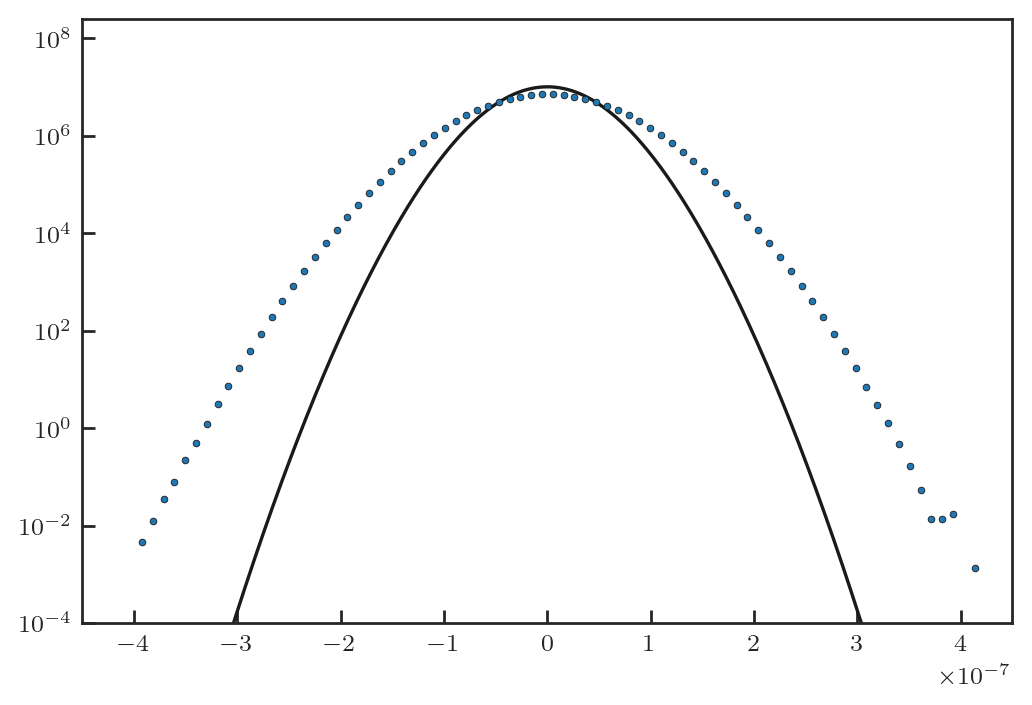

In [141]:
ax1 = plt.subplot(111)

ax1.semilogy(dxx, PDF_theo_court/np.trapz(PDF_theo_court, dxx), "-k")
ax1.semilogy(dx_1, Mean1/ Z1,".", color="tab:blue")

ax1.set_xlim([-0.45e-6, 0.45e-6])
ax1.set_ylim([1e-4, None])

# Plots

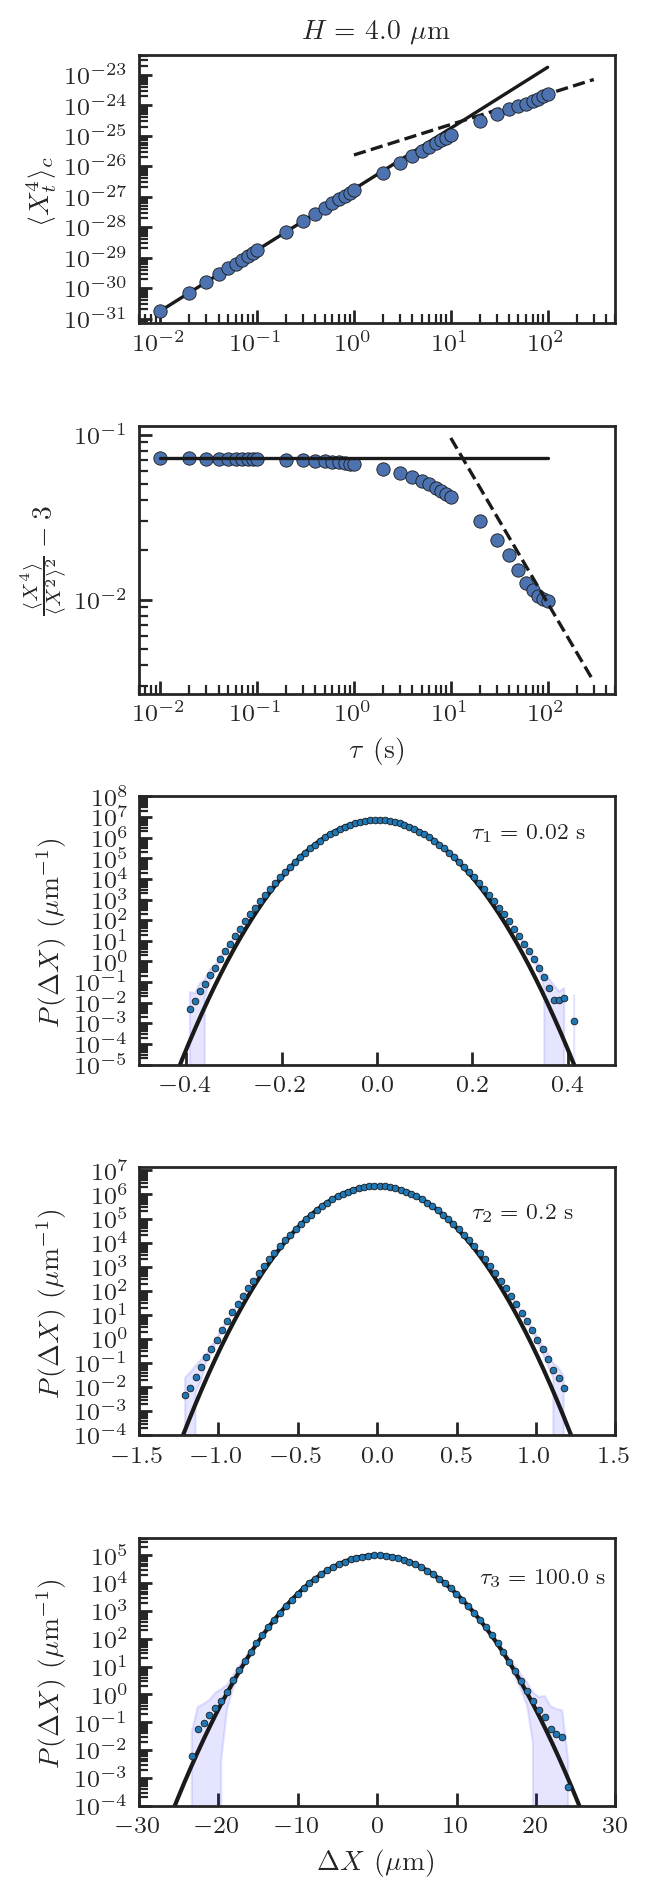

In [122]:
fig = plt.figure(figsize = (3.3, 16/1.68),  tight_layout=True)

ax0= plt.subplot(511)
ax0.plot(dtCOURT, A4_theo_x*dtCOURT**2, "k-")
ax0.plot(dtLONG, D4_long_theo*dtLONG-C4_long_theo, "k--")
ax0.loglog(dt_s_C4, C_4, "o", )
ax0.set(
    # xlabel = r"$\tau$ $(\mathrm{s})$",
    ylabel = r"$\langle X^4_t \rangle_c$",
)
ax0.set_title(r"$H=$ "+ str(H*1e6) + r" $\mu$m")
locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax0.yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1,numticks=100)
ax0.yaxis.set_minor_locator(locmin)
ax0.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())



ax0p5= plt.subplot(512)
ax0p5.loglog(dt_s_C4, Kurtosis, "o",)
ax0p5.plot(dtCOURT, np.ones(len(dtCOURT))*A4_theo_x/(4*mean_Dx**2), "k-")
ax0p5.plot(np.linspace(1e1, 3e2, 1000), D4_long_theo/(4*mean_Dx**2) / np.linspace(1e1, 3e2, 1000) , "k--")

ax0p5.set(
    xlabel = r"$\tau$ $(\mathrm{s})$",
    ylabel = r"$\frac{\langle X^4 \rangle }{ \langle X^2 \rangle^2} - 3$",
)
locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax0p5.yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1,
                                      numticks=100)
ax0p5.yaxis.set_minor_locator(locmin)
ax0p5.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())





ax1 = plt.subplot(513)
Min = np.min(data_1, axis=0)
Max = np.max(data_1, axis=0)
ax1.semilogy(dxCOURT, gauss1/np.trapz(gauss1, dxCOURT*1e-6)  , "-", color="k", linewidth=1.5,)
ax1.semilogy(dx_1*1e6, Mean1/ Z1,".", color="tab:blue")
ax1.fill_between(dx_1*1e6, Min / Z1, Max / Z1, color='blue', alpha=0.1)

ax1.text(0.2, 1e6, r"$\tau_1 = $ "+ str(dt_s_C4[Ntau1]) + " s", fontsize=8)
ax1.set_xlim(-0.5, 0.5)
ax1.set_ylim(1e-5, 1e8)
ax1.set(
    # xlabel = r"$\Delta x$ ($\mu$m)",
    ylabel = r"$P(\Delta X)$ ($\mu$m$^{-1}$)",
)
# ax1.text(-0.28, 10, r"(a)", transform=ax1.transData)
locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax1.yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1,
                                      numticks=100)
ax1.yaxis.set_minor_locator(locmin)
ax1.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())





ax2 = plt.subplot(514)
Min = np.min(data_2, axis=0)
Max = np.max(data_2, axis=0)
ax2.semilogy(dxMID, gauss2/np.trapz(gauss2, dxMID*1e-6) , "-", color="k", linewidth=1.5,)
ax2.semilogy(dx_2*1e6, Mean2/ Z2,".", color="tab:blue")
ax2.fill_between(dx_2*1e6, Min / Z2, Max / Z2, color='blue', alpha=0.1)


ax2.set_xlim(-1.5, 1.5)
ax2.set_ylim(1e-4, None)
ax2.text(0.6, 1e5, r"$\tau_2 = $ "+ str(dt_s_C4[Ntau2]) + " s", fontsize=8)
ax2.set(
    # xlabel = r"$\Delta x$ ($\mu$m)",
    ylabel = r"$P(\Delta X)$ ($\mu$m$^{-1}$)",
)
# ax2.text(-12, 1e-1, r"(b)", transform=ax2.transData) `  
locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax2.yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1,numticks=100)
ax2.yaxis.set_minor_locator(locmin)
ax2.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())



ax3 = plt.subplot(515)
Min = np.min(data_3, axis=0)
Max = np.max(data_3, axis=0)
ax3.semilogy(dxLONG, gauss3/np.trapz(gauss3, dxLONG*1e-6) , "-", color="k", linewidth=1.5,)
ax3.semilogy(dx_3*1e6, Mean3/ Z3, ".", color="tab:blue")
ax3.fill_between(dx_3*1e6, Min / Z3, Max / Z3, color='blue', alpha=0.1)

ax3.set_xlim(-30, 30)
ax3.set_ylim(1e-4, None)
ax3.text(13, 1e4, r"$\tau_3 = $ "+ str(dt_s_C4[Ntau3]) + " s", fontsize=8)
ax3.set(
    xlabel = r"$\Delta X$ ($\mu$m)",
    ylabel = r"$P(\Delta X)$ ($\mu$m$^{-1}$)",
)
# ax3.text(-42, 4e-2, r"(c)", transform=ax3.transData)  

locmaj = mpl.ticker.LogLocator(base=10.0, subs=(1.0, ), numticks=100)
ax3.yaxis.set_major_locator(locmaj)
locmin = mpl.ticker.LogLocator(base=10.0, subs=np.arange(2, 10) * .1,
                                      numticks=100)
ax3.yaxis.set_minor_locator(locmin)
ax3.yaxis.set_minor_formatter(mpl.ticker.NullFormatter())


fig.tight_layout()

# plt.savefig("../Figures/AVEC-Mersenne-TRewister_Petit-Gap.pdf")

# Teste sur des petits gap avec Mersenne Twister

(-2.3e-06, 2.3e-06)

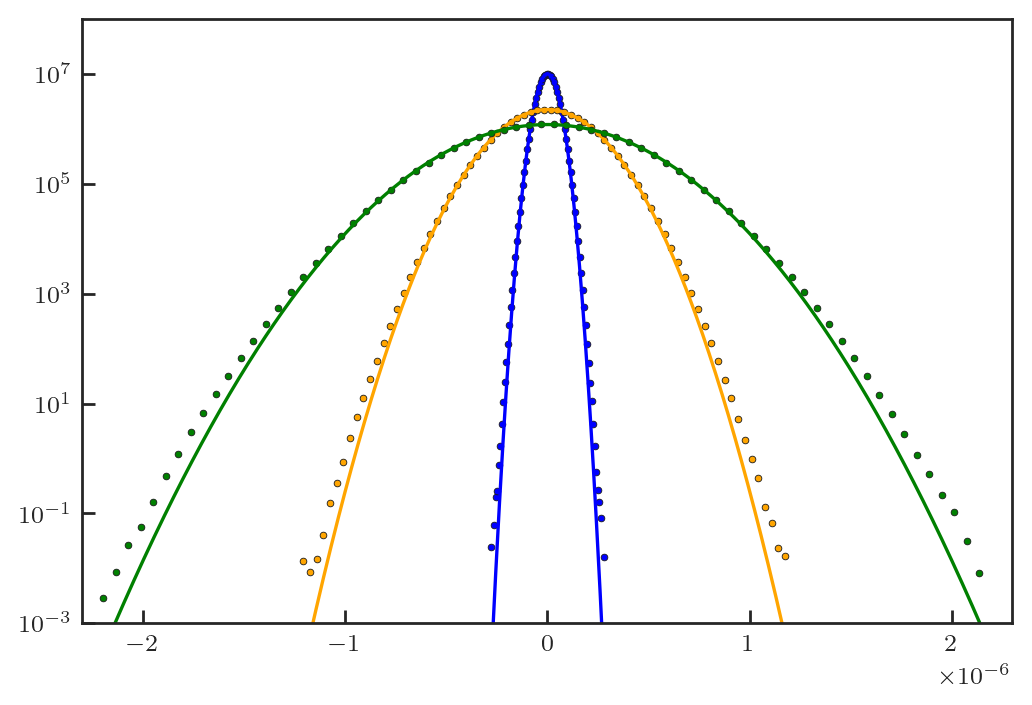

In [15]:
# test = np.load("../a.npy")
test = np.load("data_calcul_pdf_4um/1.npy")
dx_test = np.linspace(-2.3e-6, 2.3e-6, 1000)
Color= ["blue", "orange", "green"]

for n, i in enumerate([0, 10, 15]):
    plt.semilogy(dX_hist[i,:], test[i,:] / np.trapz(test[i,:], dX_hist[i,:]), ".", color=Color[n])
    gaussian = gauss(x=dx_test, mu=0, std=np.sqrt(2*mean_Dx*dt_s_C4[i]))
    plt.plot(dx_test, gaussian/np.trapz(gaussian,dx_test), "-", color=Color[n])

plt.ylim([1e-3, 1e8])
plt.xlim([-2.3e-6, 2.3e-6])
# plt.savefig("../Figures/Test-AlgoMersenne_Petit-Gap.pdf")